# KNN algorithm


In [1]:
import numpy as np
from numpy import *
from scipy.spatial import distance
from collections import Counter

## Creating a spark session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('KMeans').getOrCreate()

In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.sql.functions import *
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.sql.functions import monotonically_increasing_id

In [4]:
##Creating a data frame
data= spark.read.csv('bank-full.csv',inferSchema=True,header=True,sep=';')

In [5]:
data

DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, y: string]

In [ ]:
# TO convert categorical to numerical using label encoding

In [6]:
def ConvertCategoricaltoNumeric(Dataframe,column):
    indexer = StringIndexer(inputCol=column, outputCol= "Numeric" + column)
    indexed = indexer.fit(Dataframe).transform(Dataframe)
    encoder = OneHotEncoder(inputCol="Numeric" + column, outputCol="categoryVec" + column)
    encoded = encoder.transform(indexed)
    return encoded

In [7]:
categoricalcolumns = []
for name,coltype in data.dtypes:
    if coltype == 'string':
        categoricalcolumns.append(name)

In [8]:
modData = data
for col in categoricalcolumns:
    modData = ConvertCategoricaltoNumeric(column = col, Dataframe = modData)

In [9]:
# TO remove the categorical columns
modData = modData.drop('job')
modData = modData.drop('martial')
modData = modData.drop('education')
modData = modData.drop('housing')
modData = modData.drop('default')
modData = modData.drop('loan')
modData = modData.drop('month')
modData = modData.drop('day')
modData = modData.drop('poutcome')
modData = modData.drop('categoryVecy')
modData = modData.drop('marital')
modData = modData.drop('y')




In [10]:
doubleColumnList = []
intColumnList = []
VectorColumnList = []

for name,coltype in modData.dtypes:
    if coltype == 'int':
        intColumnList.append(name)
    if coltype == 'double':
        doubleColumnList.append(name)
    if coltype == 'vector':
        VectorColumnList.append(name)

In [11]:
#Creaing a vector of features
Assembler = VectorAssembler(inputCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'Numericjob',
                                                 'Numericmarital','Numericeducation', 'Numericdefault','Numerichousing','Numericloan',
                                               'Numericcontact','Numericmonth','Numericpoutcome'],
                                  outputCol = "features")`
output = Assembler.transform(modData)
final_data = output.select('features','Numericy')
#Splitting into train and test in the ratio of 70:30
(train, test) = final_data.randomSplit([0.7, 0.3])

In [12]:
#Calculate distance for a test sample with all the training points
def DistanceMapper(row,k,data):
   
    fixed_entry = row[0]
    rowid = row[1]
    labels = []
    distances = []
    for every_training_point in data:
        trainingVector = every_training_point[0]
        dist = distance.euclidean(fixed_entry, trainingVector)
        distances.append(dist)
        label = every_training_point[1]
        labels.append(label)
    SortedLabelsDistanceBased = [x for _,x in sorted(zip(distances,labels))]
    #Distances not required as only labels are required
    TopKSortedlabels = SortedLabelsDistanceBased[:k]
    freq = Counter(TopKSortedlabels)
    Label = freq.most_common(1)[0][0]
    return(Label)

In [13]:
train_broadcast = spark.sparkContext.broadcast(train.rdd.collect())
res1 = test.withColumn("id", monotonically_increasing_id())
df = res1.limit(5)
TestRdd = df.select(['features','id']).rdd


In [27]:
TestRdd.collect()

[Row(features=SparseVector(15, {0: 26.0, 1: 160.0, 2: 252.0, 3: 4.0, 4: -1.0}), id=0),
 Row(features=SparseVector(15, {0: 28.0, 1: 4.0, 2: 310.0, 3: 1.0, 4: -1.0}), id=1),
 Row(features=SparseVector(15, {0: 28.0, 1: 8.0, 2: 196.0, 3: 1.0, 4: -1.0}), id=2),
 Row(features=SparseVector(15, {0: 29.0, 1: -20.0, 2: 140.0, 3: 3.0, 4: -1.0}), id=3),
 Row(features=SparseVector(15, {0: 29.0, 1: 1052.0, 2: 147.0, 3: 1.0, 4: -1.0}), id=4)]

In [20]:
type(Sample)

list

In [30]:
res1.count()

13683

In [14]:
#SPlitting the dataset into 10 and loading the dataset into batches
df1,df2,df3,df4,df5,df6,df7,df8,df9,df10 = res1.randomSplit([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])

In [43]:
df1.count()

1365

In [44]:
df2.count()

1392

In [42]:
len([1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])

10

In [49]:
df2

DataFrame[features: vector, Numericy: double, id: bigint]

In [45]:
dataframes = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [51]:
#Computing the labels for the test samples using map
output = []
for i,df in zip(range(len(dataframes)),dataframes):
    print("Dataset :{}- Processing".format(i+1))
    TestRdd = df.select(['features','id']).rdd
    k = 5
    keyA = TestRdd.map(lambda row:(DistanceMapper(row,k,train_broadcast.value)))
    output.append(keyA.collect())
    print("---END---")
    

Dataset :1- Processing
---END---
Dataset :2- Processing
---END---
Dataset :3- Processing
---END---
Dataset :4- Processing
---END---
Dataset :5- Processing
---END---
Dataset :6- Processing
---END---
Dataset :7- Processing
---END---
Dataset :8- Processing
---END---
Dataset :9- Processing
---END---
Dataset :10- Processing
---END---


In [52]:
output

[[1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [53]:
len(output)

10

In [54]:
len(output[1])

1392

In [55]:
df1

DataFrame[features: vector, Numericy: double, id: bigint]

In [63]:
Actual = res1.select('Numericy').collect()

In [66]:
len(Actual)

13683

In [74]:
TrueLabels = []
for every_row in Actual:
    TrueLabels.append(every_row[0])

In [68]:
TrueLabels

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [75]:
PredictedLabel = []
for i in output:
    PredictedLabel.append(i)

In [79]:
PredictedLabel = output[0] + output[1] + output[2]+ output[3] + output[4] + output[5] + output[6] + output[7] + output[8] + output[9]


In [80]:
len(PredictedLabel)

13683

In [ ]:
#Accuracy score

In [56]:
from sklearn.metrics import accuracy_score

In [81]:
score = accuracy_score(PredictedLabel,TrueLabels)

In [82]:
score

0.84031279690126437

In [58]:
import pickle
with open('PredictedYVal.pkl', 'wb') as f:
    pickle.dump(output, f)

In [95]:
import pickle
with open('TrueLabels.pkl', 'wb') as f:
    pickle.dump(TrueLabels, f)

In [96]:
import pickle
with open('PredictedLabel.pkl', 'wb') as f:
    pickle.dump(PredictedLabel, f)

In [ ]:
#Precision recall f1 score - classwise

In [83]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
precision_recall_fscore_support(PredictedLabel,TrueLabels)
confusion_matrix(PredictedLabel,TrueLabels)

array([[11378,  1448],
       [  737,   120]])

In [84]:
precision_recall_fscore_support(PredictedLabel,TrueLabels)

(array([ 0.93916632,  0.07653061]),
 array([ 0.88710432,  0.14002334]),
 array([ 0.91239325,  0.09896907]),
 array([12826,   857], dtype=int64))

In [85]:
freq = Counter(TrueLabels)
Label = freq.most_common(1)[0][0]

In [86]:
Label

0.0

In [87]:
freq

Counter({0.0: 12115, 1.0: 1568})

In [88]:
freq = Counter(PredictedLabel)
Label = freq.most_common(1)[0][0]

In [89]:
freq

Counter({0.0: 12826, 1.0: 857})

In [7]:
#######################################################################################################


In [8]:
#verification in pandas - read csv

In [7]:
import pandas as pd


In [12]:
pandasdf = pd.read_csv("bank-full.csv",sep = ';')
pandasdf

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [9]:
categoricalcolumns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [13]:
categoricalcolumns.remove('y')

In [14]:
categoricalcolumns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [15]:
NumericBankDF = pd.get_dummies(pandasdf,columns = categoricalcolumns)

In [16]:
NumericBankDF

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,no,0,1,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
5,35,231,5,139,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
6,28,447,5,217,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
7,42,2,5,380,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
8,58,121,5,50,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1
9,43,593,5,55,1,-1,0,no,0,0,...,0,0,1,0,0,0,0,0,0,1


In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [ ]:
DF = le.fit_transform(NumericBankDF['y'])
DF

In [31]:
Target = DF

In [22]:
le.classes_

array(['no', 'yes'], dtype=object)

In [25]:
le.inverse_transform([1])

array(['yes'], dtype=object)

In [26]:
le.inverse_transform([0])

array(['no'], dtype=object)

In [27]:
del NumericBankDF['y']

In [32]:
NumericBankDF['Outcome'] = Target

In [33]:
NumericBankDF['Outcome']

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
45181    0
45182    1
45183    0
45184    0
45185    1
45186    0
45187    1
45188    1
45189    0
45190    1
45191    1
45192    1
45193    1
45194    0
45195    1
45196    1
45197    1
45198    0
45199    0
45200    1
45201    1
45202    1
45203    1
45204    1
45205    1
45206    1
45207    1
45208    1
45209    0
45210    0
Name: Outcome, Length: 45211, dtype: int64

In [35]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(NumericBankDF, test_size=0.2)

In [43]:
type(NumericBankDF.values)

numpy.ndarray

In [44]:
NumericBankDF.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'Outcome'],
      dtype='object')

In [54]:
Columns = list(NumericBankDF.columns)

In [55]:
Columns

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown',
 'Outcome']

In [56]:
Columns.remove('Outcome')

In [57]:
Columns

['age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_no',
 'default_yes',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_failure',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown']

In [64]:
FeatureDF = NumericBankDF[[x for x in Columns]]

In [65]:
FeatureDF

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,151,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,76,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,92,1,-1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,198,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
5,35,231,5,139,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,28,447,5,217,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,42,2,5,380,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
8,58,121,5,50,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
9,43,593,5,55,1,-1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [66]:
from sklearn.neighbors import NearestNeighbors

In [67]:
train, test

(       age  balance  day  duration  campaign  pdays  previous  job_admin.  \
 21325   47     1219   18       697         4     -1         0           0   
 40043   29     1739    3       114         1     -1         0           0   
 29476   35        0    3        80         1    273         1           1   
 36005   38     1612    8       423         1     -1         0           0   
 4961    31      891   21        44         3     -1         0           0   
 9170    37        0    5       309         2     -1         0           0   
 38467   48      244   15        54         5     -1         0           0   
 15503   29     -193   18       126         2     -1         0           1   
 41274   34      745   25        76         1     -1         0           1   
 3356    54     2933   15       144         2     -1         0           0   
 120     56       56    5       439         1     -1         0           0   
 17102   46     -160   25        93        11     -1         0  

In [76]:
trainFeatures = train[[x for x in Columns]]

In [77]:
testFeatures = test[[x for x in Columns]]

In [78]:
trainTarget = train['Outcome']

In [88]:
TrueLabels = test['Outcome']

In [80]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(trainFeatures, trainTarget) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [91]:
PredictedLabels = neigh.predict(testFeatures)

In [84]:
Targetlabel

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [92]:
from sklearn.metrics import accuracy_score
score = accuracy_score(PredictedLabels,TrueLabels)

In [93]:
score

0.87979652770098415

In [94]:
#Now lets just do label encoding


In [100]:
NumericBankDF

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,Outcome
0,58,2143,5,261,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,44,29,5,151,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,33,2,5,76,1,-1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
3,47,1506,5,92,1,-1,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
4,33,1,5,198,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
5,35,231,5,139,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
6,28,447,5,217,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
7,42,2,5,380,1,-1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
8,58,121,5,50,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
9,43,593,5,55,1,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [104]:
OriginalColumns = list(pandasdf.columns)
OriginalColumns.remove('y')

In [113]:
OriginalColumns

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome']

In [111]:
LabelEncoderDF =pandasdf.apply(le.fit_transform)


In [114]:
LabelEncoderDF

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,40,4,1,2,0,3036,1,0,2,4,8,261,0,0,0,3,0
1,26,9,2,1,0,945,1,0,2,4,8,151,0,0,0,3,0
2,15,2,1,1,0,918,1,1,2,4,8,76,0,0,0,3,0
3,29,1,1,3,0,2420,1,0,2,4,8,92,0,0,0,3,0
4,15,11,2,3,0,917,0,0,2,4,8,198,0,0,0,3,0
5,17,4,1,2,0,1147,1,0,2,4,8,139,0,0,0,3,0
6,10,4,2,2,0,1363,1,1,2,4,8,217,0,0,0,3,0
7,24,2,0,2,1,918,1,0,2,4,8,380,0,0,0,3,0
8,40,5,1,0,0,1037,1,0,2,4,8,50,0,0,0,3,0
9,25,9,2,1,0,1509,1,0,2,4,8,55,0,0,0,3,0


In [116]:
train, test = train_test_split(LabelEncoderDF, test_size=0.2)
OriginalColumns = list(LabelEncoderDF.columns)
OriginalColumns.remove('y')

In [117]:
trainFeatures = train[[x for x in OriginalColumns]]
testFeatures = test[[x for x in OriginalColumns]]
trainTarget = train['y']
testTarget = test['y']

In [118]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(trainFeatures, trainTarget) 
PredictedLabels = neigh.predict(testFeatures)

from sklearn.metrics import accuracy_score
score = accuracy_score(PredictedLabels,TrueLabels)

In [119]:
score

0.82914961848943936

In [120]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [123]:
MinMaxTrainingFeatures = scaler.fit_transform(trainFeatures)
MinMaxTestingFeatures = scaler.fit_transform(testFeatures)

In [124]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(MinMaxTrainingFeatures, trainTarget) 
PredictedLabels = neigh.predict(MinMaxTestingFeatures)

from sklearn.metrics import accuracy_score
score = accuracy_score(PredictedLabels,TrueLabels)

In [125]:
score

0.83644808138891957

In [4]:
import os 
import pickle
os.chdir("A:\\UNCC\\Fall 2017\\CC\\Project\Bank")
       
with open('TrueLabels.pkl', 'rb') as f:
    TrueLabels = pickle.load(f)

with open('PredictedLabel.pkl', 'rb') as f:
    PredictedLabel = pickle.load(f)
    

In [6]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(TrueLabels,PredictedLabel)
cm

array([[11378,   737],
       [ 1448,   120]])

In [10]:
import matplotlib.pyplot as plt
import pylab as pl

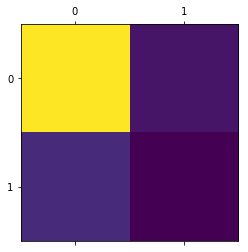

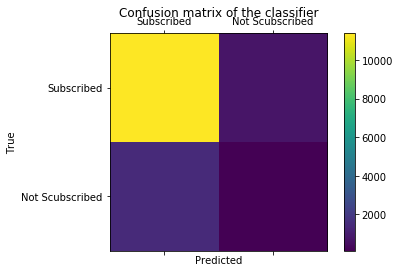

In [11]:
labels = ['Subscribed', 'Not Scubscribed']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()